In [37]:
import os
import shutil
import time
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import PIL.Image
from glob import glob
import cv2
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets

**Connect to google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
shared_filepath = '/content/drive/MyDrive/Data/'

In [4]:
filepath = '/content/drive/MyDrive/cs523/'

**Training**

In [10]:
training_path = shared_filepath+"train"
classes = [c for c in os.listdir(training_path) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [6]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

Total number of training data : 20405


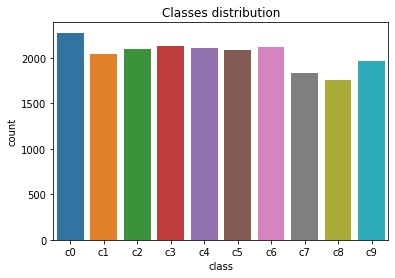

In [11]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(training_path,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sns.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

In [7]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomRotation(10),
                                 transforms.ToTensor()])

**Splitting into train and validation datasets**

In [13]:
data = datasets.ImageFolder(root = training_path, transform = transform)

total_len = len(data)
training_len = int(0.9*total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [21]:
training_len

18364

In [22]:
testing_len

2041

**Checking GPU**

In [49]:
device = torch.device("cuda:0")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
A100-SXM4-40GB


**Loading the train and validation data**

In [25]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

**Training the model**

In [35]:
def train_model(model, criterion, optimizer, scheduler, n_epochs):# = 10):
    
    losses = []
    accuracies = []
    val_accuracies = []
    model.train()
    for epoch in tqdm(range(n_epochs)):
        print("\nStarting epoch ",epoch+1)
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()
        test_acc = validation_model(model)
        val_accuracies.append(test_acc)
        torch.save(model.state_dict(), filepath+'model_resnet_epoch{}.pth'.format(epoch+1)) 
      
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, val_accuracies

In [36]:
def validation_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the validation images: %d %%' % (
        test_acc))
    return test_acc

In [37]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 10) #No. of classes = 10
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, duration: 233 s, loss: 0.2407, acc: 92.4270
Accuracy of the network on the validation images: 98 %


 10%|█         | 1/10 [04:15<38:19, 255.51s/it]

Epoch 2, duration: 230 s, loss: 0.0238, acc: 99.3195
Accuracy of the network on the validation images: 99 %


 20%|██        | 2/10 [08:28<33:52, 254.12s/it]

Epoch 3, duration: 237 s, loss: 0.0102, acc: 99.7060
Accuracy of the network on the validation images: 99 %


 30%|███       | 3/10 [12:49<30:01, 257.41s/it]

Epoch 4, duration: 239 s, loss: 0.0072, acc: 99.7822
Accuracy of the network on the validation images: 99 %


 40%|████      | 4/10 [17:13<25:58, 259.73s/it]

Epoch 5, duration: 235 s, loss: 0.0084, acc: 99.7713
Accuracy of the network on the validation images: 99 %


 50%|█████     | 5/10 [21:30<21:34, 258.96s/it]

Epoch 6, duration: 231 s, loss: 0.0029, acc: 99.9183
Accuracy of the network on the validation images: 99 %


 60%|██████    | 6/10 [25:44<17:08, 257.09s/it]

Epoch 7, duration: 230 s, loss: 0.0012, acc: 99.9673
Accuracy of the network on the validation images: 99 %


 70%|███████   | 7/10 [29:56<12:46, 255.61s/it]

Epoch 8, duration: 230 s, loss: 0.0011, acc: 99.9619
Accuracy of the network on the validation images: 99 %


 80%|████████  | 8/10 [34:09<08:29, 254.74s/it]

Epoch 9, duration: 243 s, loss: 0.0008, acc: 99.9673
Accuracy of the network on the validation images: 99 %


 90%|█████████ | 9/10 [38:36<04:18, 258.56s/it]

Epoch 10, duration: 236 s, loss: 0.0007, acc: 99.9728
Accuracy of the network on the validation images: 99 %


100%|██████████| 10/10 [42:55<00:00, 257.53s/it]

Finished Training


In [39]:
training_accs

[92.42704703832753,
 99.31946864111498,
 99.70601045296168,
 99.78222996515679,
 99.77134146341463,
 99.9183362369338,
 99.96733449477352,
 99.96189024390245,
 99.96733449477352,
 99.9727787456446]

In [40]:
test_accs

[98.23615874571288,
 99.4610485056345,
 99.70602645761882,
 99.80401763841255,
 99.75502204801568,
 99.80401763841255,
 99.70602645761882,
 99.65703086722195,
 99.75502204801568,
 99.80401763841255]

<Figure size 432x288 with 0 Axes>

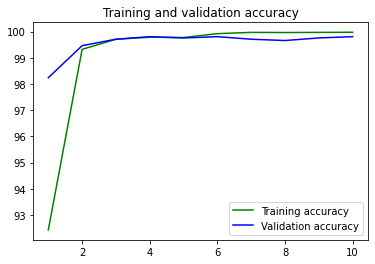

<Figure size 432x288 with 0 Axes>

In [6]:
plt.plot(range(1,11), training_accs, 'g', label='Training accuracy')
plt.plot(range(1,11), test_accs, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

**Testing**

In [8]:
model_test = models.resnet50()
num_ftrs = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs, 10)
##load the model which we chose where there was no overfitting
model_test.load_state_dict(torch.load(filepath+"/model_resnet_epoch5.pth"))
model_test.eval()
model_test.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
path_test = shared_filepath+"TestData"

In [15]:
def true_pred(test_data,model_test):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.argmax(model_test(x),dim=1)
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    return y_true,y_pred

In [16]:
testing_data = datasets.ImageFolder(root = path_test, transform = transform)

total_test_len = len(testing_data)

In [17]:
testing_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                           batch_size=32,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)

In [18]:
y_true,y_pred = true_pred(testing_loader,model_test)

100%|██████████| 64/64 [00:12<00:00,  4.94it/s]


**Performance metrics**

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.9182763744427934

In [23]:
precision = precision_score(y_true,y_pred,average='micro')
print('Precision: ', precision)

Precision:  0.9182763744427934


In [22]:
f1 = f1_score(y_true,y_pred,average='micro')
print('F1 score: ', f1)

F1 score:  0.9182763744427934


In [24]:
recallscore = recall_score(y_true,y_pred,average='micro')
print('Recall score: ', recallscore)

Recall score:  0.9182763744427934


**Top 2 accuracy**

In [25]:
def topk_pred(test_data,model,k):
    y_true = []
    y_pred = []
    n = len(test_data)
    sum = 0
    with torch.no_grad():
        for x,y in tqdm(test_data):
            x = x.to(device)
            pred = torch.topk(model(x), k).indices
            y_true.extend(list(np.array(y)))
            y_pred.extend(list(np.array(pred.cpu())))
    positivecount = 0
    for i in range(len(y_true)):
      if y_true[i] in y_pred[i]:
        positivecount += 1

    return positivecount/len(y_true)

In [26]:
top2_acc = topk_pred(testing_loader,model_test,2)

100%|██████████| 64/64 [00:13<00:00,  4.90it/s]


In [27]:
top2_acc

0.95789995047053

In [28]:
from sklearn.metrics import classification_report
final_repo = classification_report(y_true, y_pred, zero_division=1,target_names = list(class_dict.values()))
print(final_repo)

                              precision    recall  f1-score   support

                safe driving       0.81      0.65      0.72       214
             texting - right       1.00      1.00      1.00       224
talking on the phone - right       1.00      1.00      1.00       221
              texting - left       0.98      0.98      0.98       220
 talking on the phone - left       0.93      0.98      0.95       223
         operating the radio       0.86      1.00      0.93       226
                    drinking       1.00      1.00      1.00       203
             reaching behind       0.95      1.00      0.97       169
             hair and makeup       0.99      0.75      0.86       159
        talking to passenger       0.65      0.74      0.69       160

                    accuracy                           0.92      2019
                   macro avg       0.92      0.91      0.91      2019
                weighted avg       0.92      0.92      0.92      2019



**Confusion Matrix**

In [29]:
confusionMatrix = confusion_matrix(y_true,y_pred)

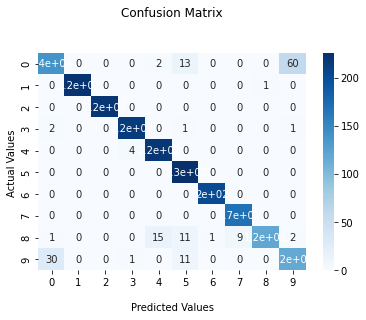

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

ax = sns.heatmap(confusionMatrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

**Displaying images with predictions and ground truth**

In [32]:
dataList = pd.read_csv(filepath+'driver_imgs_list.csv')

In [39]:
files = np.random.choice(dataList[dataList['subject'].isin(['p012','p026'])]['img'].tolist(),9)

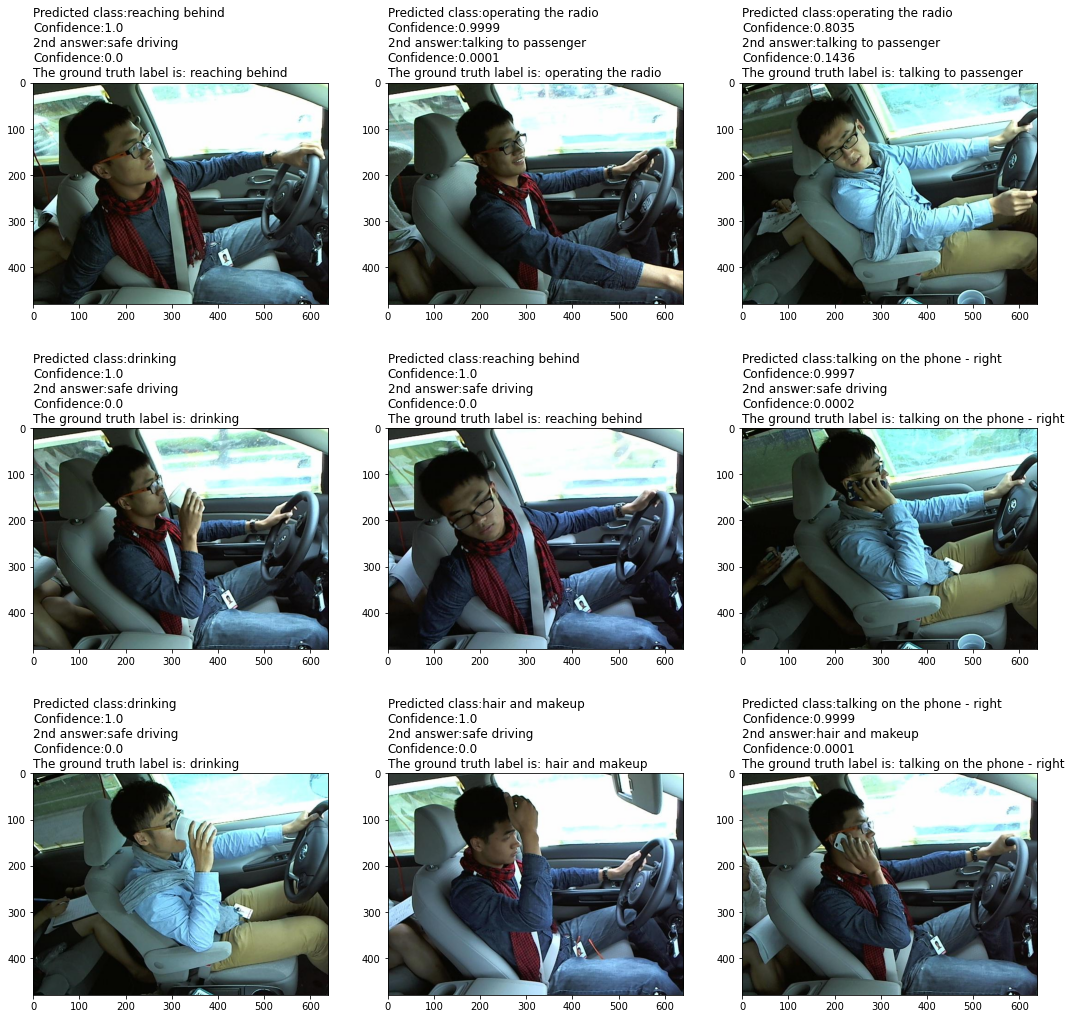

In [43]:
from pandas.io.parsers.readers import TextFileReader
plt.figure(figsize=(18,18))
text_list = []

for i in range(len(files)):
    plt.subplot(3,3,i+1)   
    img = cv2.imread(glob(shared_filepath+'TestData/*/'+files[i])[0])
    img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cvt)
    with PIL.Image.open(glob(shared_filepath+'TestData/*/'+files[i])[0]) as im:
      im = transform(im)
      im = im.unsqueeze(0)
      output = model_test(im.cuda())
      proba = nn.Softmax(dim=1)(output)
      proba = [round(float(elem),4) for elem in proba[0]]
      proba2 = proba.copy()
      proba2[proba2.index(max(proba2))] = 0.
      text  = "Predicted class:"+class_dict[proba.index(max(proba))]+"\n"+"Confidence:"+str(max(proba))+"\n"+"2nd answer:"+class_dict[proba2.index(max(proba2))]+"\n"+"Confidence:"+str(max(proba2))+"\n"+"The ground truth label is: "+class_dict[int(dataList[dataList['img'] == files[i]]["classname"].iloc[0][1:])]
      text_list.append(text)
      

    plt.title(text, loc='left')



plt.show()

**GradCAM**

In [44]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch

from torchvision import transforms
from glob import glob
from PIL import Image

def gradcammap(model_test,file):

  target_layers = [model_test.layer4[-1]]
  convert_tensor = transforms.ToTensor()
  img = Image.open(glob(shared_filepath+'TestData/*/'+file)[0])
  input_tensor = convert_tensor(img).unsqueeze(0)

  cam = GradCAM(model=model_test, target_layers=target_layers, use_cuda=device)
  grayscale_cam = cam(input_tensor=input_tensor)

  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(np.asarray(img,dtype="float32")/255, grayscale_cam, use_rgb=True)
  return visualization

In [46]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


In [47]:
img_vis_lst = []
for file in files:
  img_vis_lst.append(gradcammap(model_test,file))

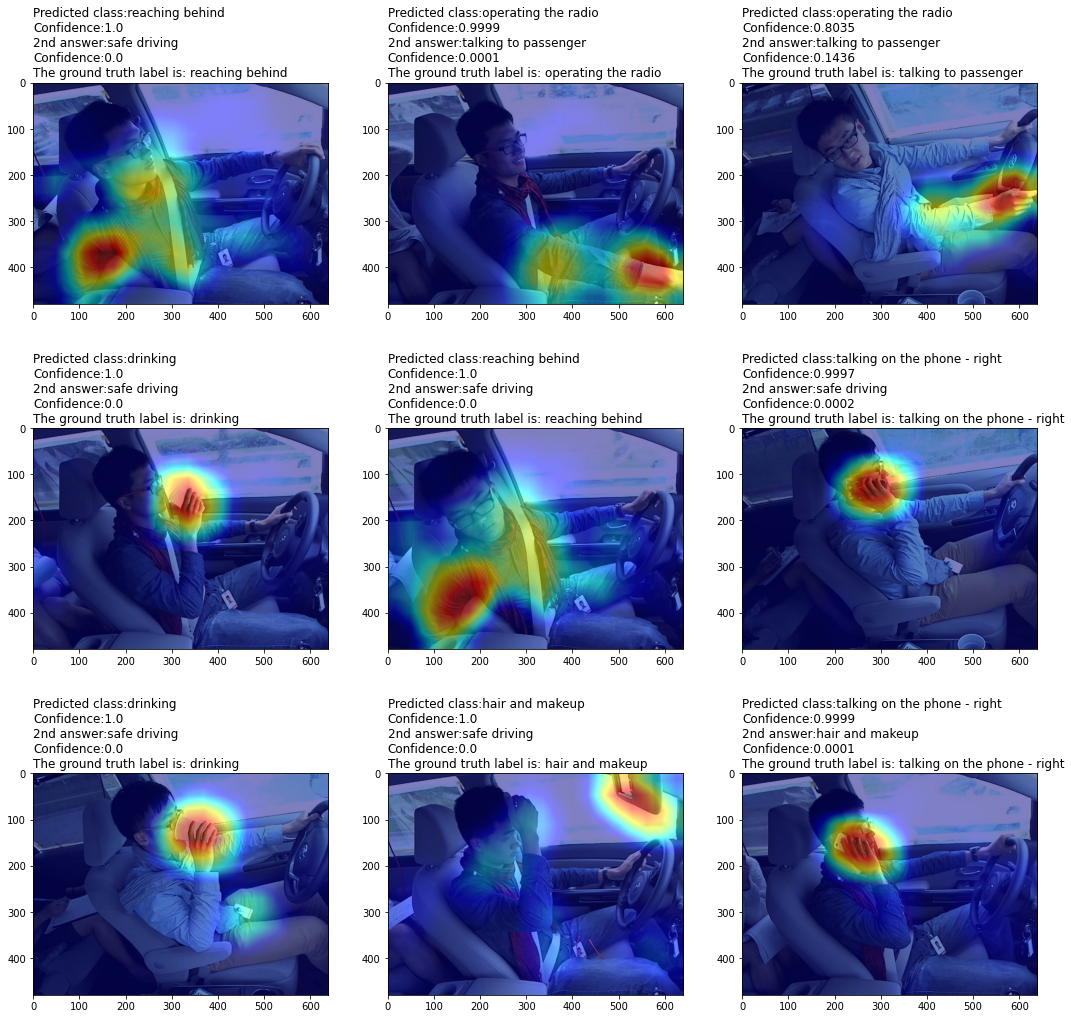

In [48]:
plt.figure(figsize=(18,18))

for i in range(len(img_vis_lst)):
    plt.subplot(3,3,i+1)   
    plt.imshow(img_vis_lst[i])
    plt.title(text_list[i], loc='left')